# `CNModel` Tutorial

Trey V. Wenger (c) April 2025

Here we demonstrate the basic features of the `CNModel` model. The `CNModel` models the hyperfine spectral structure of ${\rm CN}$ and $^{13}{\rm CN}$ including non-LTE effects. Please review the `bayes_spec` documentation and tutorials for a more thorough description of the steps outlined in this tutorial: https://bayes-spec.readthedocs.io/en/stable/index.html

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("arviz version:", az.__version__)

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

arviz version: 0.22.0dev
pymc version: 5.21.1
bayes_spec version: 1.7.8
bayes_cn_hfs version: 2.0.0-staging+0.g7afe3a8.dirty


## `supplement_mol_data`

Here we model the hyperfine structure of CN emission. We use the helper function `supplement_mol_data` to download the molecular data for this molecule.

In [2]:
from bayes_cn_hfs import supplement_mol_data

mol_data_12CN, mol_weight_12CN = supplement_mol_data("CN")
print(mol_data_12CN.keys())
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Upper state degrees of freedom:", mol_data_12CN['degu'])
print("Lower state energy level (erg)", mol_data_12CN['El'])
print("Upper state energy level (erg)", mol_data_12CN['Eu'])
print("Relative intensities", mol_data_12CN['relative_int'])
print("Partition function terms:", mol_data_12CN["log10_Q_terms"])
print("Upper state quantum numbers:", mol_data_12CN["Qu"])
print("lower states quantum numbers", mol_data_12CN["Ql"])
print("state info", mol_data_12CN["states"])

dict_keys(['freq', 'Aul', 'degu', 'El', 'Eu', 'relative_int', 'log10_Q_terms', 'Qu', 'Ql', 'states', 'state_u_idx', 'state_l_idx', 'Gu', 'Gl'])
transition frequency (MHz): [113123.3687 113144.19   113170.535  113191.325  113488.142  113490.985
 113499.643  113508.934  113520.4215]
Einstein A coefficient (s-1): [1.26969616e-06 1.03939111e-05 5.07869910e-06 6.59525390e-06
 6.64784064e-06 1.17706070e-05 1.04919208e-05 5.12459350e-06
 1.28243028e-06]
Upper state degrees of freedom: [2 2 4 4 4 6 2 4 2]
Lower state energy level (erg) [1.3905121e-19 0.0000000e+00 1.3905121e-19 0.0000000e+00 1.3905121e-19
 0.0000000e+00 1.3905121e-19 0.0000000e+00 0.0000000e+00]
Upper state energy level (erg) [7.49702428e-16 7.49701340e-16 7.50014955e-16 7.50013660e-16
 7.52119441e-16 7.51999228e-16 7.52195648e-16 7.52118159e-16
 7.52194276e-16]
Relative intensities [0.01204699 0.09860036 0.09633376 0.1250773  0.12574146 0.33394774
 0.09921527 0.09691221 0.01212491]
Partition function terms: [0.40307694 0.9743

## Simulating Data

To test the model, we must simulate some data. We can do this with `CNModel`, but we must pack a "dummy" data structure first.

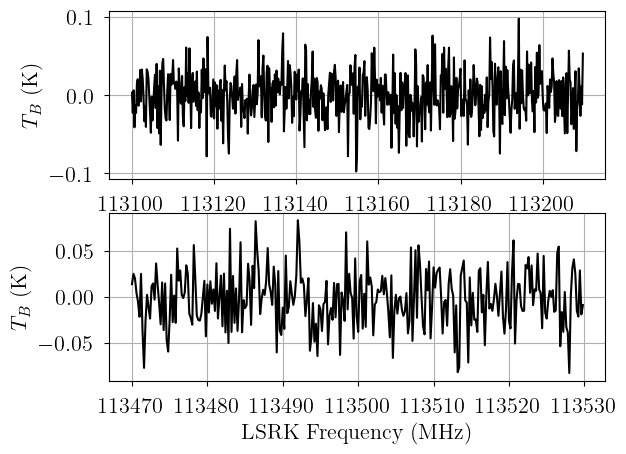

In [3]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis_1 = np.arange(113100.0, 113210.0, 0.2) # MHz
freq_axis_2 = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_1 = noise * np.random.randn(len(freq_axis_1)) # K
brightness_data_2 = noise * np.random.randn(len(freq_axis_2)) # K

# CNModel datasets can be named anything, here we name them "12CN-1" and "12CN-2"
obs_1 = SpecData(
    freq_axis_1,
    brightness_data_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    brightness_data_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
dummy_data = {"12CN-1": obs_1, "12CN-2": obs_2}

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, dummy_data["12CN-1"].brightness, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, dummy_data["12CN-2"].brightness, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the model for a given set of parameters.

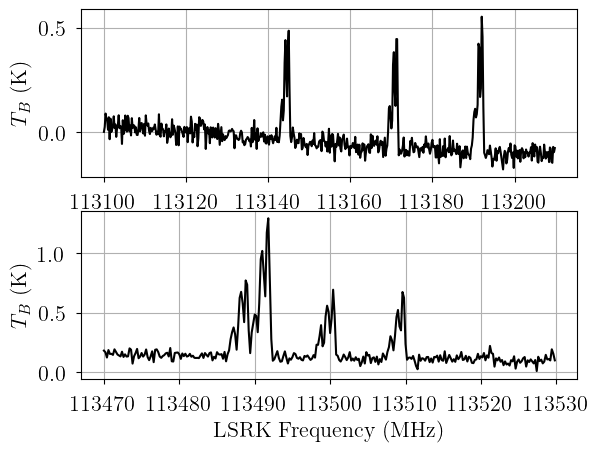

In [4]:
from bayes_cn_hfs.cn_model import CNModel

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 2 # polynomial baseline degree
model = CNModel(
    dummy_data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.5, 1.0], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [1.0, 0.5], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = excitation temperature
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX = True, # assume CTEX
    prior_log10_LTE_precision = None, # ignored for this LTE model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    clip_weights = 1.0e-9, # clip statistical weights between [clip_weights, 1-clip_weights]
    clip_tau = -10.0, # clip optical depths below to prevent masers
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N": [13.8, 13.9, 14.0],
    "log10_Tkin": [0.65, 0.6, 0.5],
    "fwhm_nonthermal": [1.0, 1.25, 1.5],
    "velocity": [-2.0, 0.0, 2.5],
    "fwhm_L": 0.0,
    "baseline_12CN-1_norm": [-2.0, -5.0, 8.0],
    "baseline_12CN-2_norm": [4.0, -2.0, 5.0],
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observations
sim_obs1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_obs2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, sim_obs1, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, sim_obs2, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

In [5]:
sim_params

{'log10_N': [13.8, 13.9, 14.0],
 'log10_Tkin': [0.65, 0.6, 0.5],
 'fwhm_nonthermal': [1.0, 1.25, 1.5],
 'velocity': [-2.0, 0.0, 2.5],
 'fwhm_L': 0.0,
 'baseline_12CN-1_norm': [-2.0, -5.0, 8.0],
 'baseline_12CN-2_norm': [4.0, -2.0, 5.0],
 'fwhm_thermal': array([0.08867757, 0.08371703, 0.07461288]),
 'fwhm': array([1.00392416, 1.25280028, 1.50185455]),
 'log10_Tex_ul': array([0.65, 0.6 , 0.5 ]),
 'LTE_weights': array([[0.17659718, 0.353274  , 0.05237634, 0.10469961, 0.05216502,
         0.10434294, 0.15654492],
        [0.18885791, 0.37781138, 0.04829246, 0.09653001, 0.04807389,
         0.09616112, 0.14427323],
        [0.21685988, 0.43385792, 0.0389559 , 0.07785605, 0.03873407,
         0.07748167, 0.11625451]]),
 'Tex': array([[4.46683592, 3.98107171, 3.16227766],
        [4.46683592, 3.98107171, 3.16227766],
        [4.46683592, 3.98107171, 3.16227766],
        [4.46683592, 3.98107171, 3.16227766],
        [4.46683592, 3.98107171, 3.16227766],
        [4.46683592, 3.98107171, 3.16227

In [6]:
# Now we pack the simulated spectrum into a new SpecData instance
obs_1 = SpecData(
    freq_axis_1,
    sim_obs1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    sim_obs2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
data = {"12CN-1": obs_1, "12CN-2": obs_2}

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `CNModel`. Here we create a new model with the simulated data. We assume LTE.

In [7]:
# Initialize and define the model
model = CNModel(
    data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.5, 1.0], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [1.0, 0.5], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = excitation temperature
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX = True, # assume CTEX
    prior_log10_LTE_precision = None, # ignored for this LTE model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    clip_weights = 1.0e-9, # clip statistical weights between [clip_weights, 1-clip_weights]
    clip_tau = -10.0, # clip optical depths below to prevent masers
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

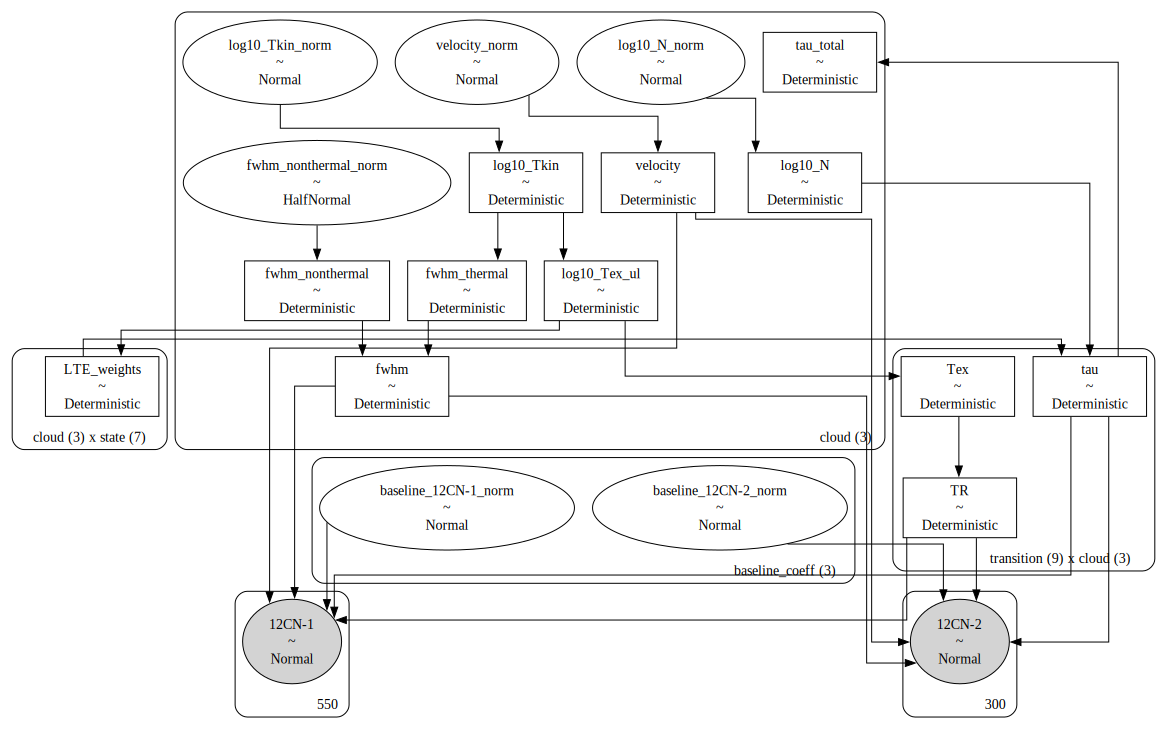

In [8]:
# Plot model graph
model.graph().render('cn_model', format='png')
model.graph()

In [9]:
# model string representation
print(model.model.str_repr())

baseline_12CN-1_norm ~ Normal(0, <constant>)
baseline_12CN-2_norm ~ Normal(0, <constant>)
       velocity_norm ~ Normal(0, 1)
     log10_Tkin_norm ~ Normal(0, 1)
fwhm_nonthermal_norm ~ HalfNormal(0, 1)
        log10_N_norm ~ Normal(0, 1)
            velocity ~ Deterministic(f(velocity_norm))
          log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
        fwhm_thermal ~ Deterministic(f(log10_Tkin_norm))
     fwhm_nonthermal ~ Deterministic(f(fwhm_nonthermal_norm))
                fwhm ~ Deterministic(f(fwhm_nonthermal_norm, log10_Tkin_norm))
             log10_N ~ Deterministic(f(log10_N_norm))
        log10_Tex_ul ~ Deterministic(f(log10_Tkin_norm))
         LTE_weights ~ Deterministic(f(log10_Tkin_norm))
                 Tex ~ Deterministic(f(log10_Tkin_norm))
                 tau ~ Deterministic(f(log10_N_norm, log10_Tkin_norm))
           tau_total ~ Deterministic(f(log10_N_norm, log10_Tkin_norm))
                  TR ~ Deterministic(f(log10_Tkin_norm))
              12CN-1 ~ Norma

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [12CN-1, 12CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tkin_norm, velocity_norm]


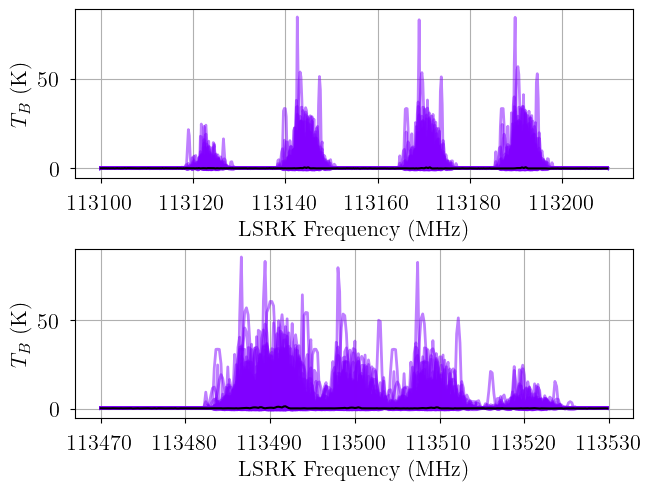

In [10]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=1000,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

We can also generate a pair plot to inspect the prior distributions and their effect on deterministic quantities. The model has several attributes to access the various free parameters (`freeRVs`) and deterministic quantities (`deterministics`). Here we show the pair plot for the deterministic quantities derived from our prior distributions. The three red points correspond to the simulation parameters ("truths") for our three clouds.

baseline_freeRVs ['baseline_12CN-1_norm', 'baseline_12CN-2_norm']
baseline_deterministics []
cloud_freeRVs ['velocity_norm', 'log10_Tkin_norm', 'fwhm_nonthermal_norm', 'log10_N_norm']
cloud_deterministics ['velocity', 'log10_Tkin', 'fwhm_thermal', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'LTE_weights', 'Tex', 'tau', 'tau_total', 'TR']
hyper_freeRVs []
hyper_deterministics []


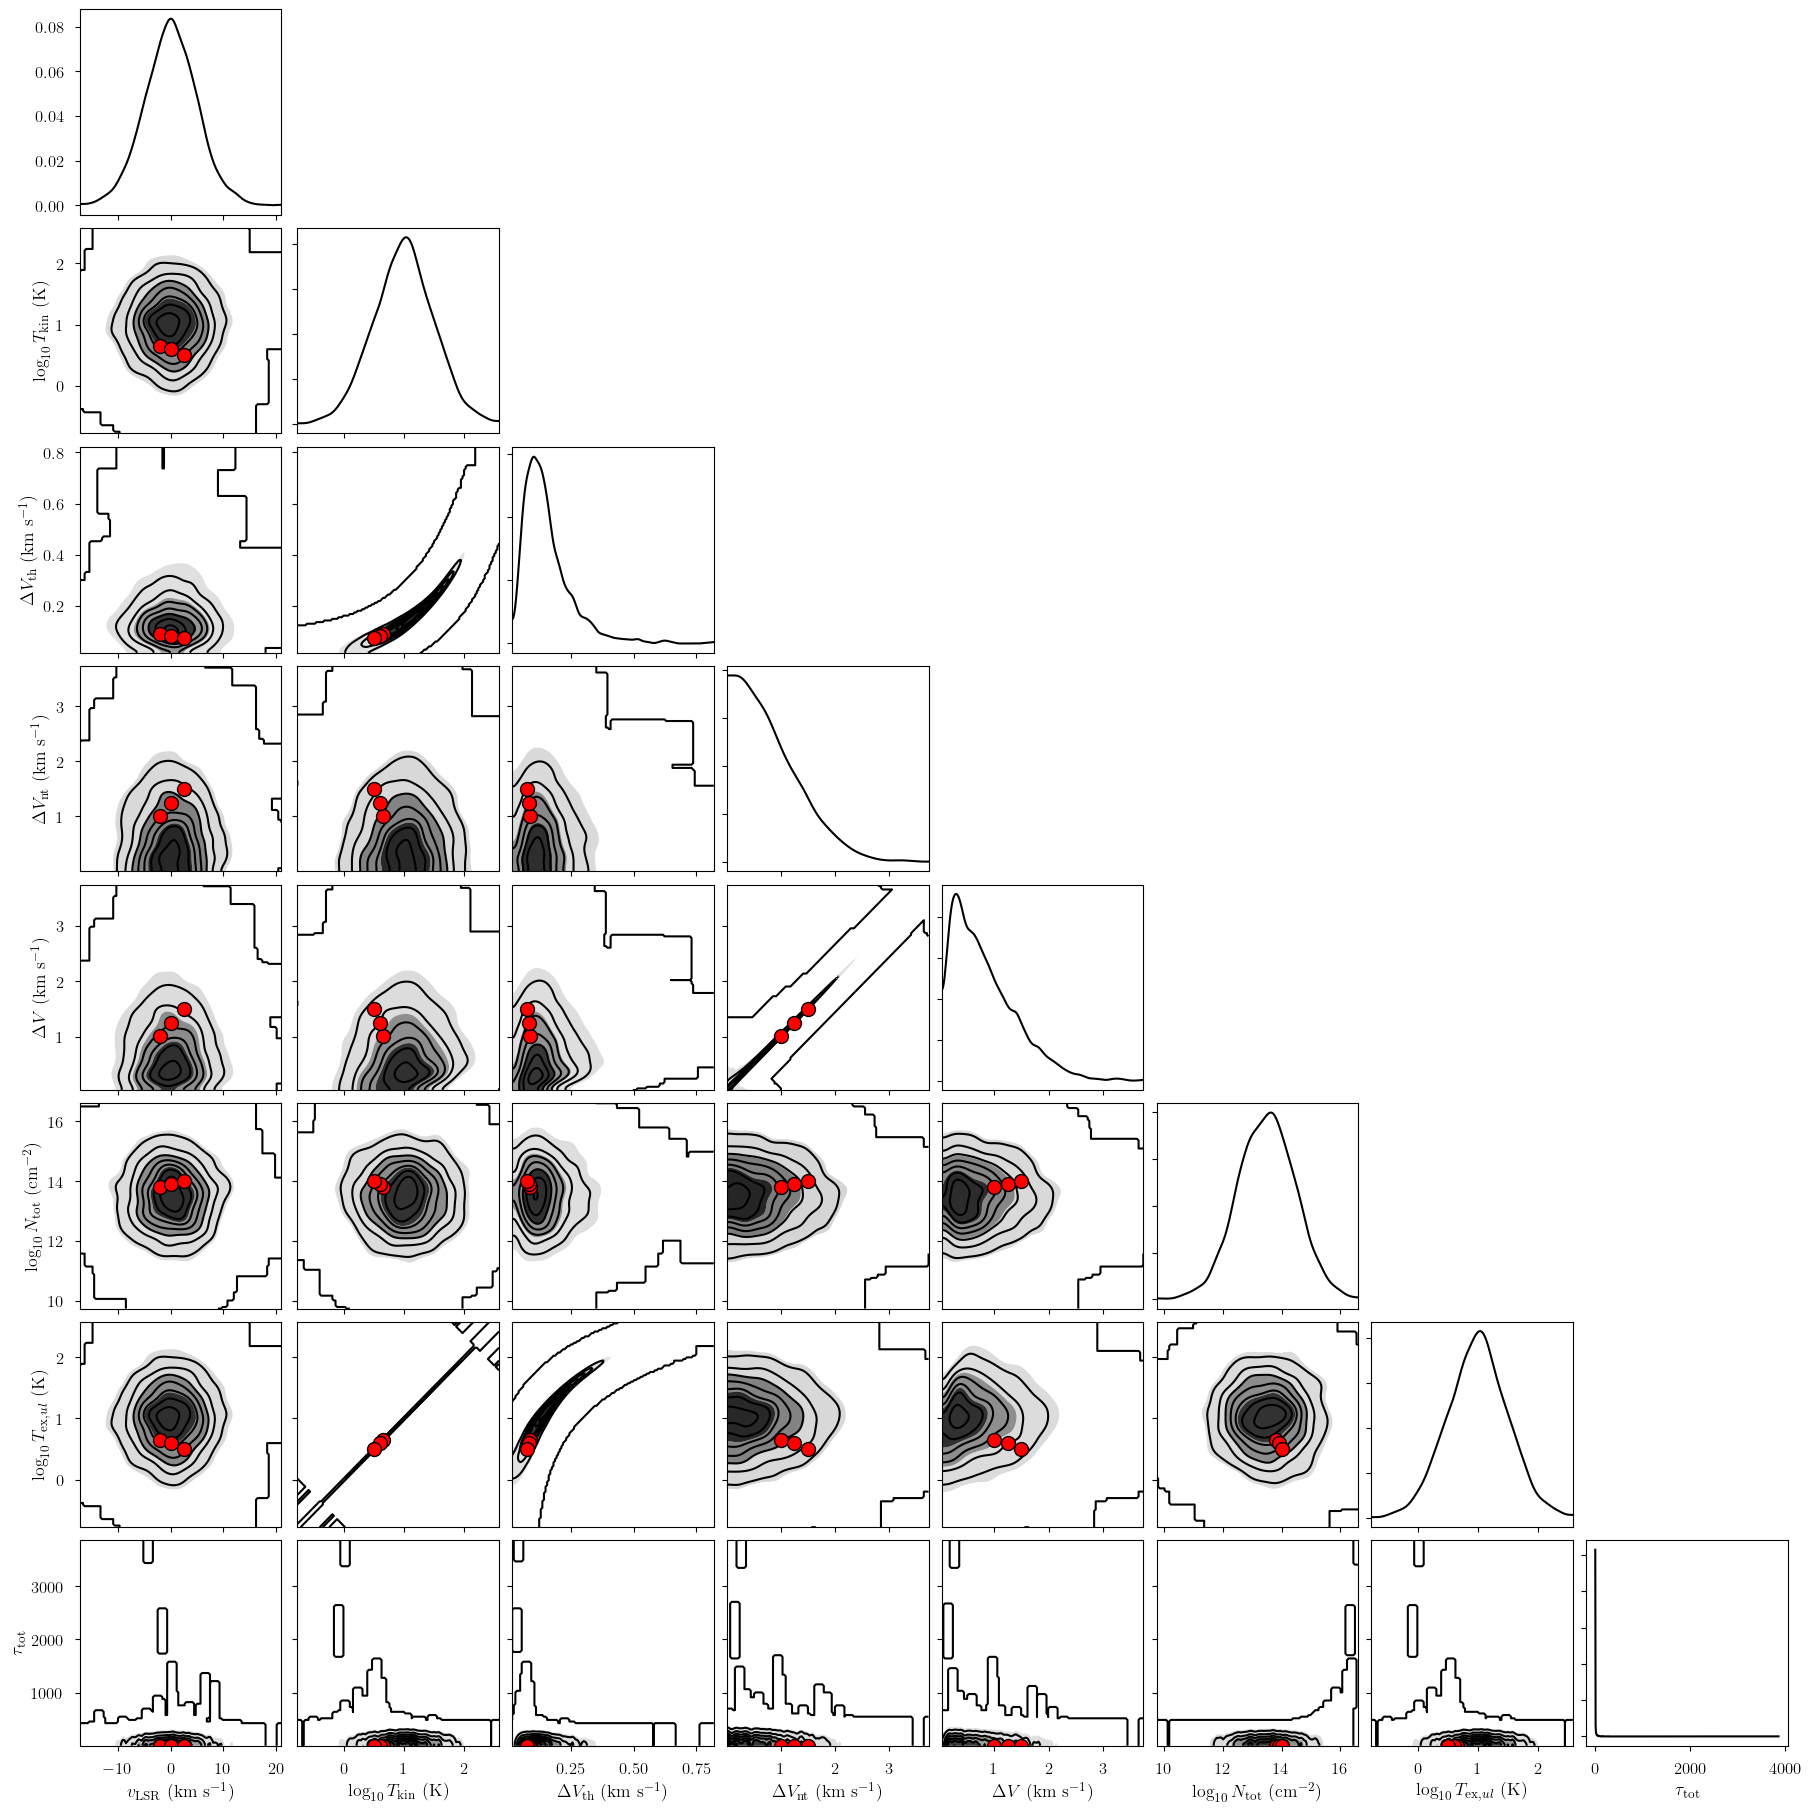

In [11]:
from bayes_spec.plots import plot_pair

# available parameter attributes:
print("baseline_freeRVs", model.baseline_freeRVs)
print("baseline_deterministics", model.baseline_deterministics)
print("cloud_freeRVs", model.cloud_freeRVs)
print("cloud_deterministics", model.cloud_deterministics)
print("hyper_freeRVs", model.hyper_freeRVs)
print("hyper_deterministics", model.hyper_deterministics)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [12]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.05, # VI relative convergence threshold
    abs_tolerance = 0.05, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 8800
Interrupted at 8,799 [8%]: Average Loss = 1,173.3


Output()

Runtime: 0.29 minutes


Sampling: [12CN-1, 12CN-2]


Output()

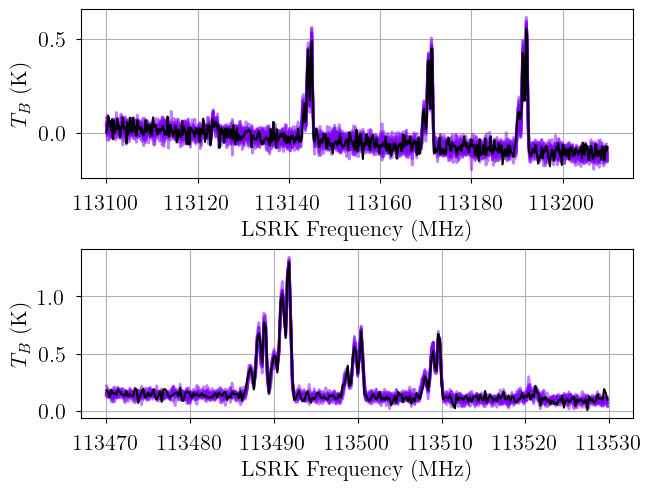

In [13]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [14]:
start = time.time()
init_kwargs = {
    "rel_tolerance": 0.05,
    "abs_tolerance": 0.05,
    "learning_rate": 0.01,
}
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = init_kwargs, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 8800
Interrupted at 8,799 [8%]: Average Loss = 1,173.3
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, log10_Tkin_norm, fwhm_nonthermal_norm, log10_N_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.


Adding log-likelihood to trace


Output()

Runtime: 1.30 minutes


In [15]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [16]:
print("solutions:", model.solutions)

pm.summary(model.trace.solution_0)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
baseline_12CN-1_norm[0]  -0.214  0.053  -0.316   -0.117      0.001    0.001   
baseline_12CN-1_norm[1]  -4.779  0.141  -5.034   -4.508      0.001    0.002   
baseline_12CN-1_norm[2]   2.186  0.793   0.684    3.617      0.008    0.008   
baseline_12CN-2_norm[0]  -0.316  0.071  -0.447   -0.183      0.001    0.001   
baseline_12CN-2_norm[1]  -1.990  0.202  -2.362   -1.599      0.002    0.002   
baseline_12CN-2_norm[2]   0.433  0.888  -1.242    2.045      0.008    0.010   
velocity_norm[0]          0.004  0.003  -0.002    0.009      0.000    0.000   
velocity_norm[1]         -0.400  0.002  -0.404   -0.397      0.000    0.000   
velocity_norm[2]          0.510  0.007   0.496    0.523      0.000    0.000   
log10_Tkin_norm[0]       -0.799  0.013  -0.823   -0.776      0.000    0.000   
log10_Tkin_norm[1]       -0.697  0.016  -0.725   -0.666      0.000    0.000   
log10_Tkin_norm[2]       -0.985  0.015  -1.012   -0.959      0.000    0.000   
log10_N_norm[0]           0.409  0.026   0.362    0.459      0.000    0.000   
log10_N_norm[1]           0.297  0.022   0.256    0.339      0.000    0.000   
log10_N_norm[2]           0.425  0.064   0.303    0.543      0.001    0.001   
fwhm_nonthermal_norm[0]   1.291  0.040   1.217    1.365      0.000    0.000   
fwhm_nonthermal_norm[1]   1.007  0.026   0.959    1.055      0.000    0.000   
fwhm_nonthermal_norm[2]   1.499  0.089   1.330    1.657      0.001    0.001   
velocity[0]               0.019  0.015  -0.009    0.046      0.000    0.000   
velocity[1]              -2.002  0.010  -2.022   -1.983      0.000    0.000   
velocity[2]               2.549  0.036   2.480    2.617      0.000    0.000   
log10_Tkin[0]             0.601  0.006   0.588    0.612      0.000    0.000   
log10_Tkin[1]             0.652  0.008   0.637    0.667      0.000    0.000   
log10_Tkin[2]             0.507  0.007   0.494    0.521      0.000    0.000   
fwhm_thermal[0]           0.084  0.001   0.083    0.085      0.000    0.000   
fwhm_thermal[1]           0.089  0.001   0.087    0.090      0.000    0.000   
fwhm_thermal[2]           0.075  0.001   0.074    0.076      0.000    0.000   
fwhm_nonthermal[0]        1.291  0.040   1.217    1.365      0.000    0.000   
fwhm_nonthermal[1]        1.007  0.026   0.959    1.055      0.000    0.000   
fwhm_nonthermal[2]        1.499  0.089   1.330    1.657      0.001    0.001   
fwhm[0]                   1.294  0.040   1.220    1.368      0.000    0.000   
fwhm[1]                   1.011  0.026   0.963    1.058      0.000    0.000   
fwhm[2]                   1.501  0.089   1.332    1.659      0.001    0.001   
log10_N[0]               13.909  0.026  13.862   13.959      0.000    0.000   
log10_N[1]               13.797  0.022  13.756   13.839      0.000    0.000   
log10_N[2]               13.925  0.064  13.803   14.043      0.001    0.001   
log10_Tex_ul[0]           0.601  0.006   0.588    0.612      0.000    0.000   
log10_Tex_ul[1]           0.652  0.008   0.637    0.667      0.000    0.000   
log10_Tex_ul[2]           0.507  0.007   0.494    0.521      0.000    0.000   
LTE_weights[0, 0 0 1 1]   0.189  0.002   0.186    0.192      0.000    0.000   
LTE_weights[0, 0 0 1 2]   0.377  0.003   0.371    0.383      0.000    0.000   
LTE_weights[0, 1 0 1 1]   0.048  0.001   0.047    0.049      0.000    0.000   
LTE_weights[0, 1 0 1 2]   0.097  0.001   0.095    0.099      0.000    0.000   
LTE_weights[0, 1 0 2 1]   0.048  0.001   0.047    0.049      0.000    0.000   
LTE_weights[0, 1 0 2 2]   0.096  0.001   0.094    0.098      0.000    0.000   
LTE_weights[0, 1 0 2 3]   0.144  0.002   0.141    0.148      0.000    0.000   
LTE_weights[1, 0 0 1 1]   0.176  0.002   0.173    0.180      0.000    0.000   
LTE_weights[1, 0 0 1 2]   0.353  0.004   0.346    0.359      0.000    0.000   
LTE_weights[1, 1 0 1 1]   0.053  0.001   0.051    0.054      0.000    0.000   
LTE_weights[1, 1 0 1 2]   0.105  0.001   0.103    0.107      0.000    0.000  

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [12CN-1, 12CN-2]


Output()

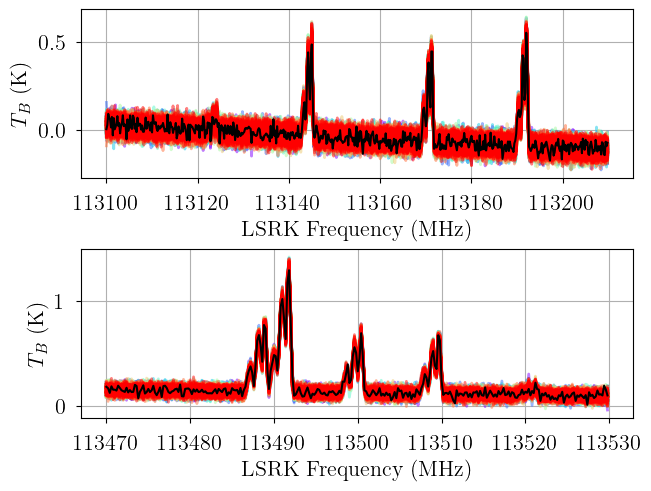

In [17]:
posterior = model.sample_posterior_predictive(
    thin=10, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

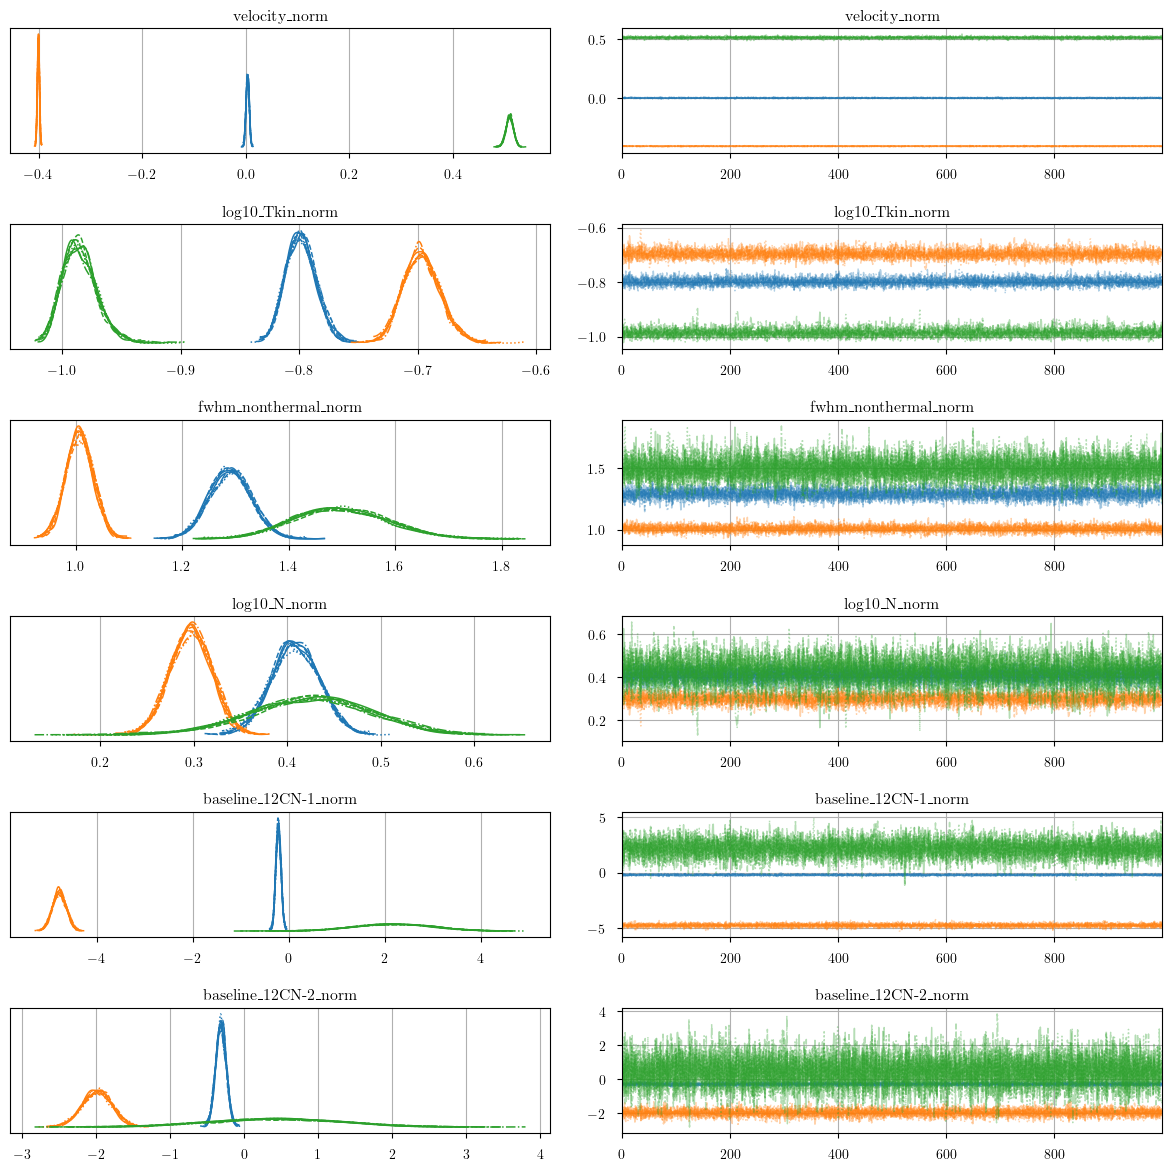

In [18]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

We can inspect the posterior distribution pair plots. The red points represent the simulation parameters.

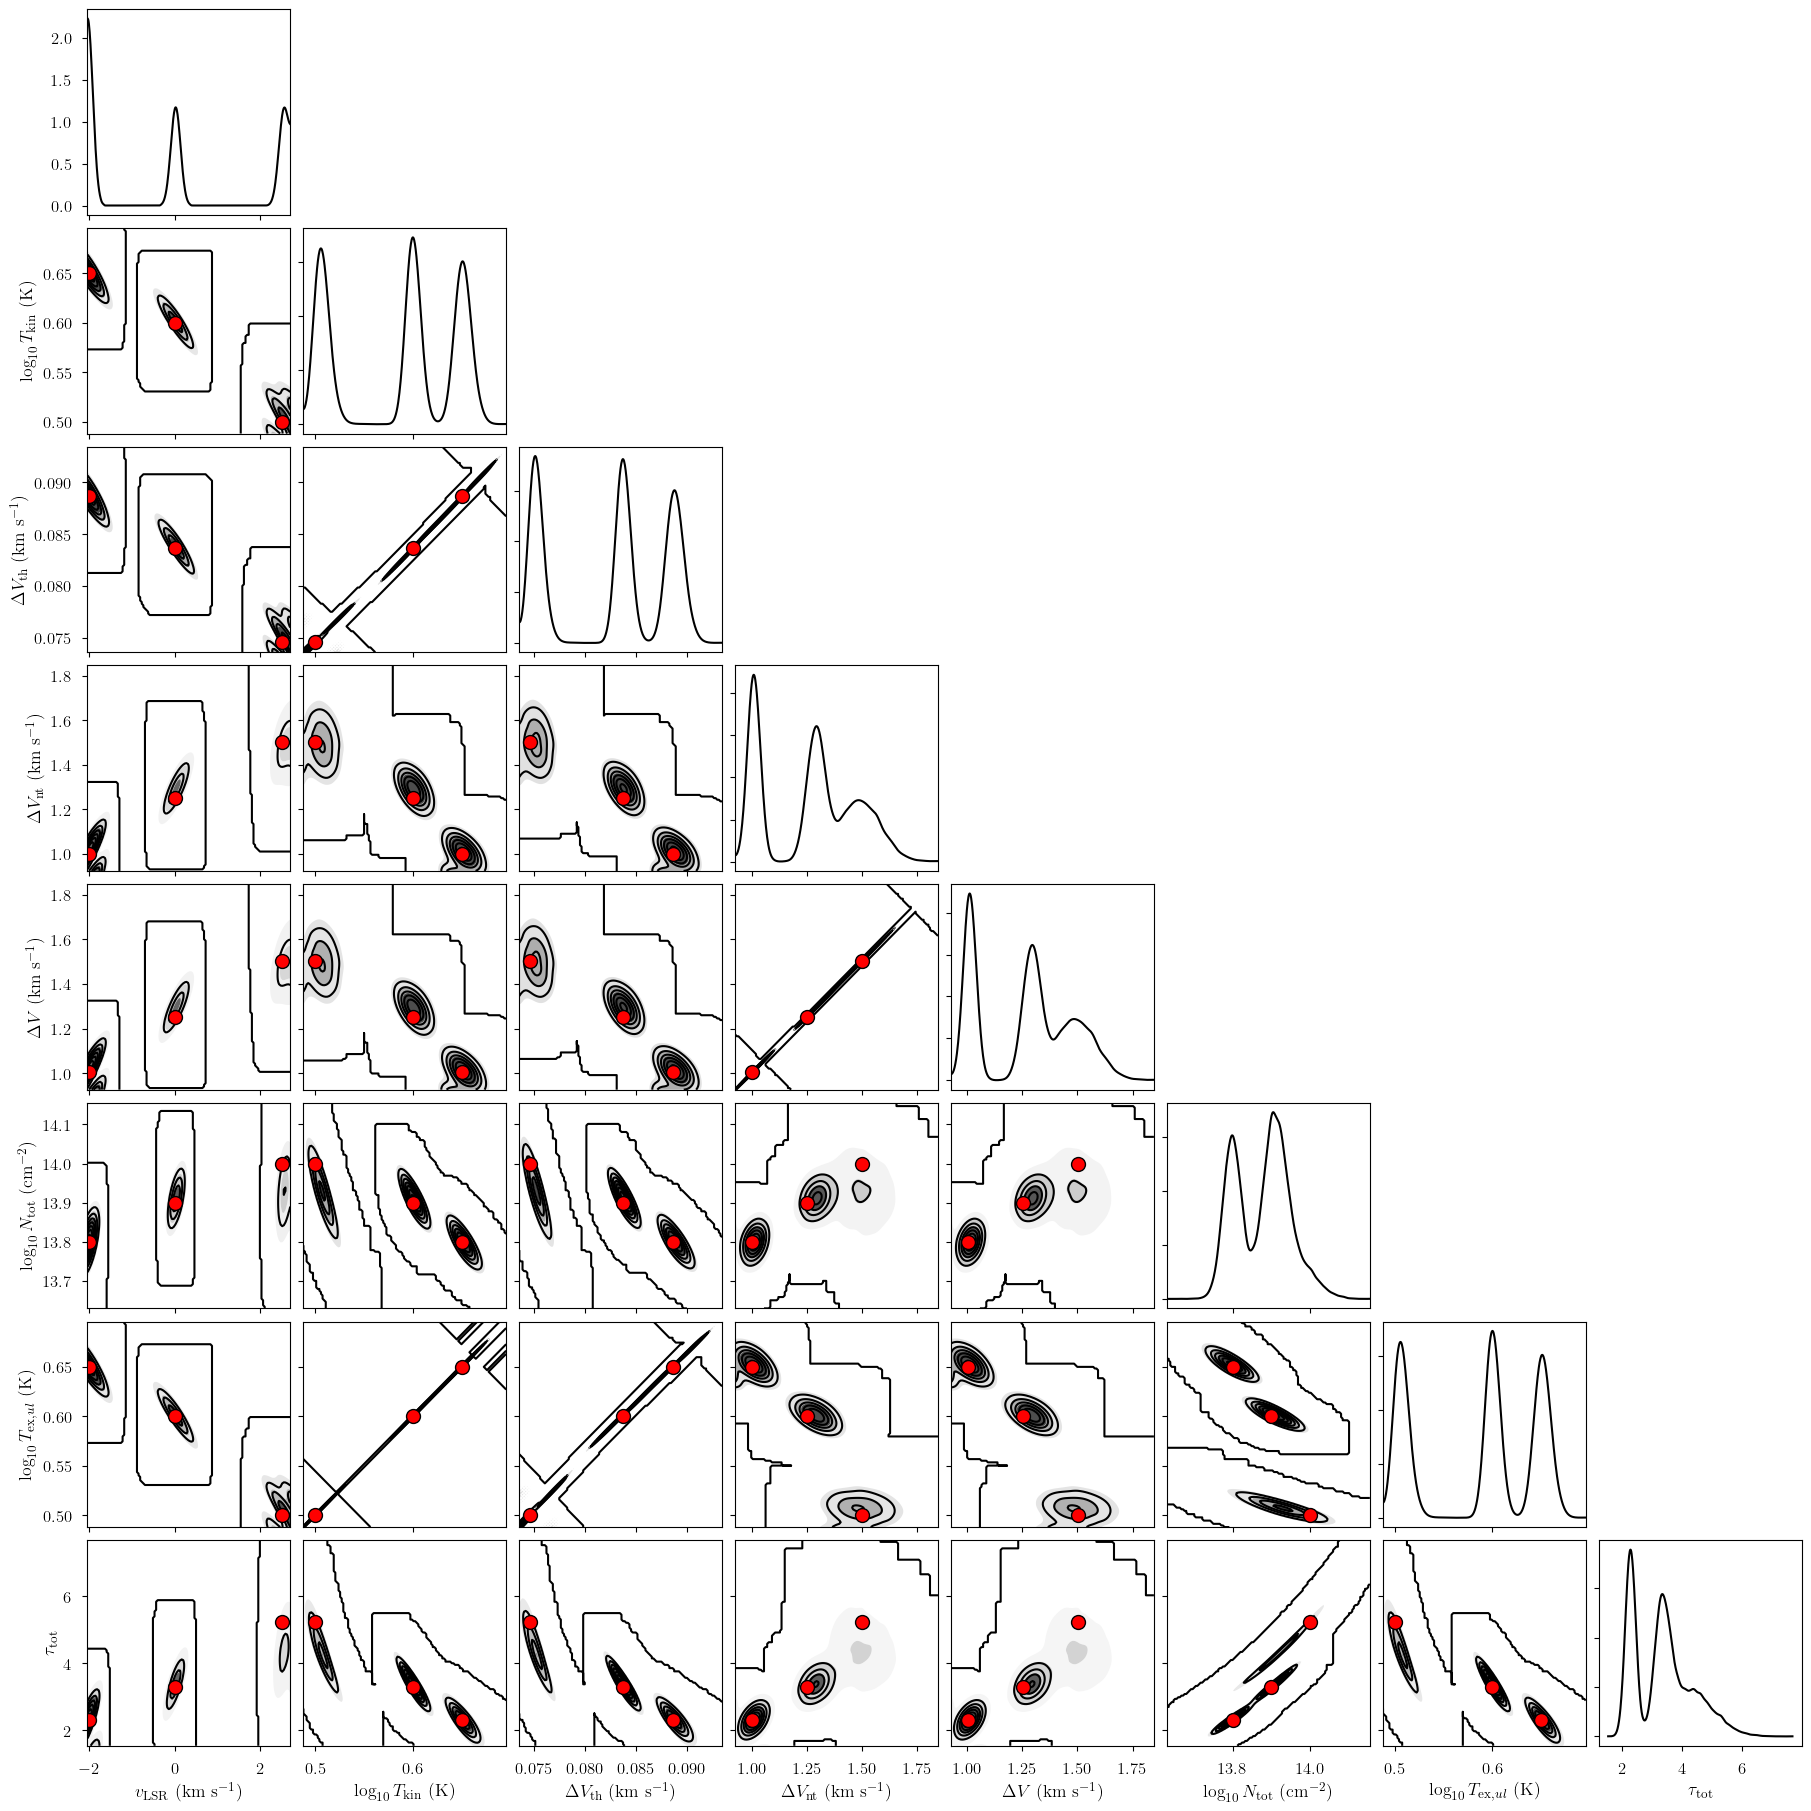

In [19]:
from bayes_spec.plots import plot_pair

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud (excluding the transition and state dependent parameters for clarity) along with the model hyper-parameters.

In [20]:
# identify simulation cloud corresponding to each posterior cloud
sim_cloud_map = {}
for i in range(n_clouds):
    posterior_velocity = model.trace.solution_0['velocity'].sel(cloud=i).data.mean()
    match = np.argmin(np.abs(sim_params["velocity"] - posterior_velocity))
    sim_cloud_map[i] = match
sim_cloud_map

{0: np.int64(1), 1: np.int64(0), 2: np.int64(2)}

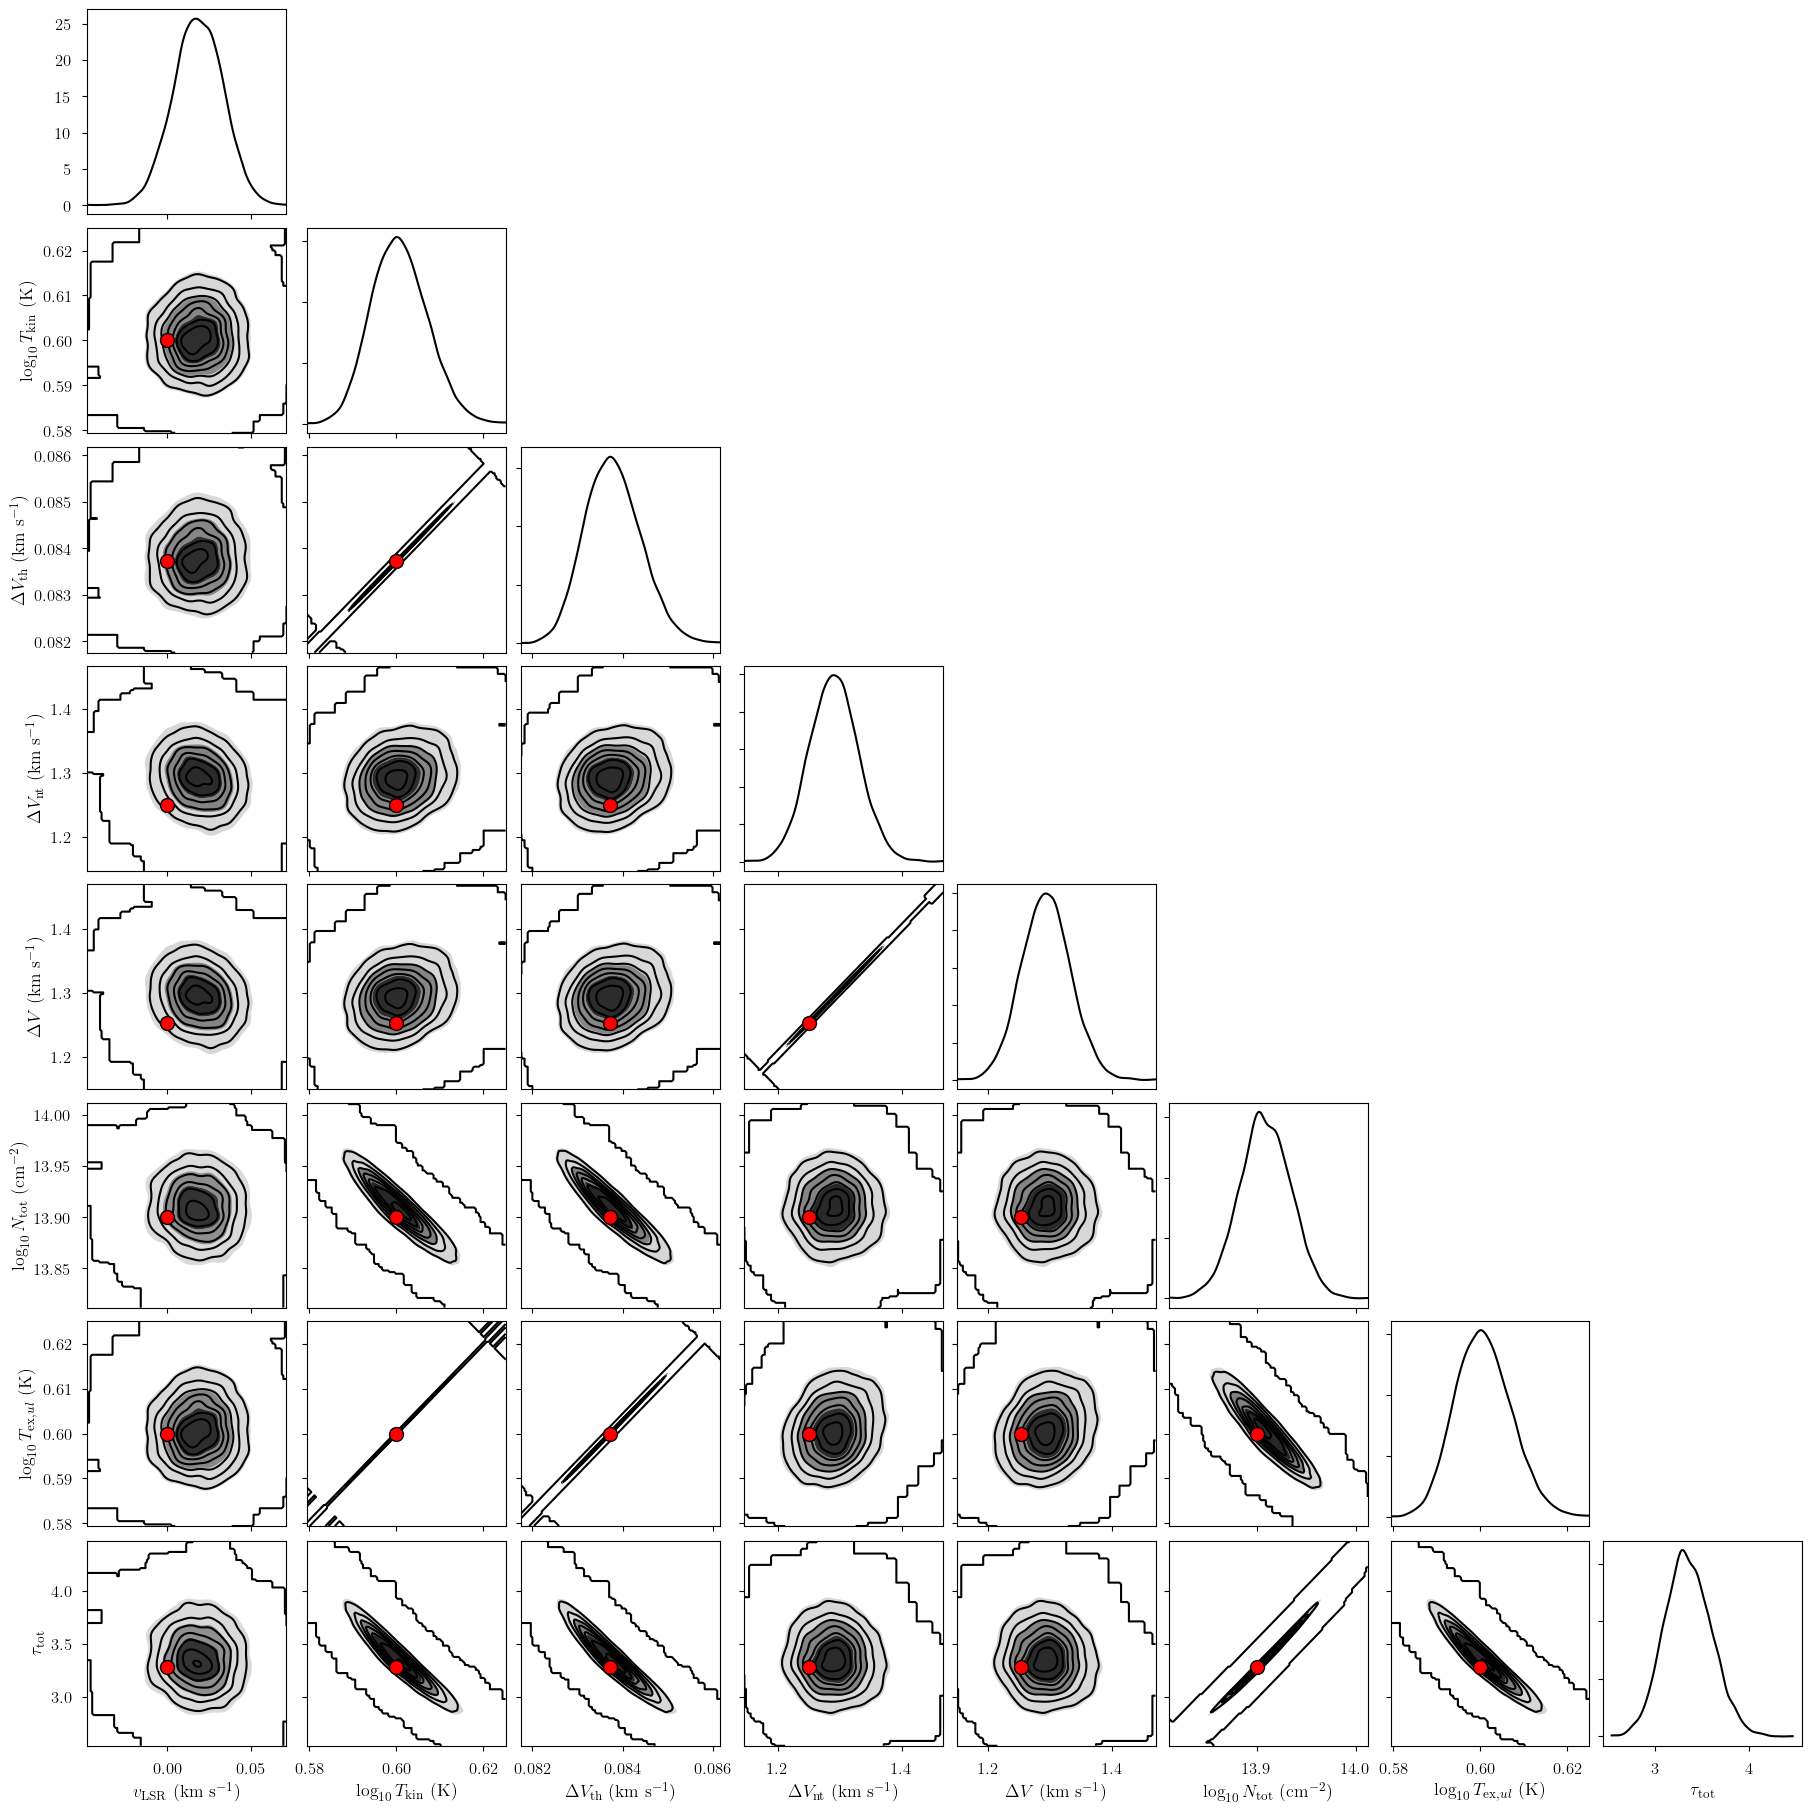

In [21]:
cloud = 0

# subset of sim_params
my_sim_params = {}
for var_name in model.cloud_deterministics:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=my_sim_params, # truths
)

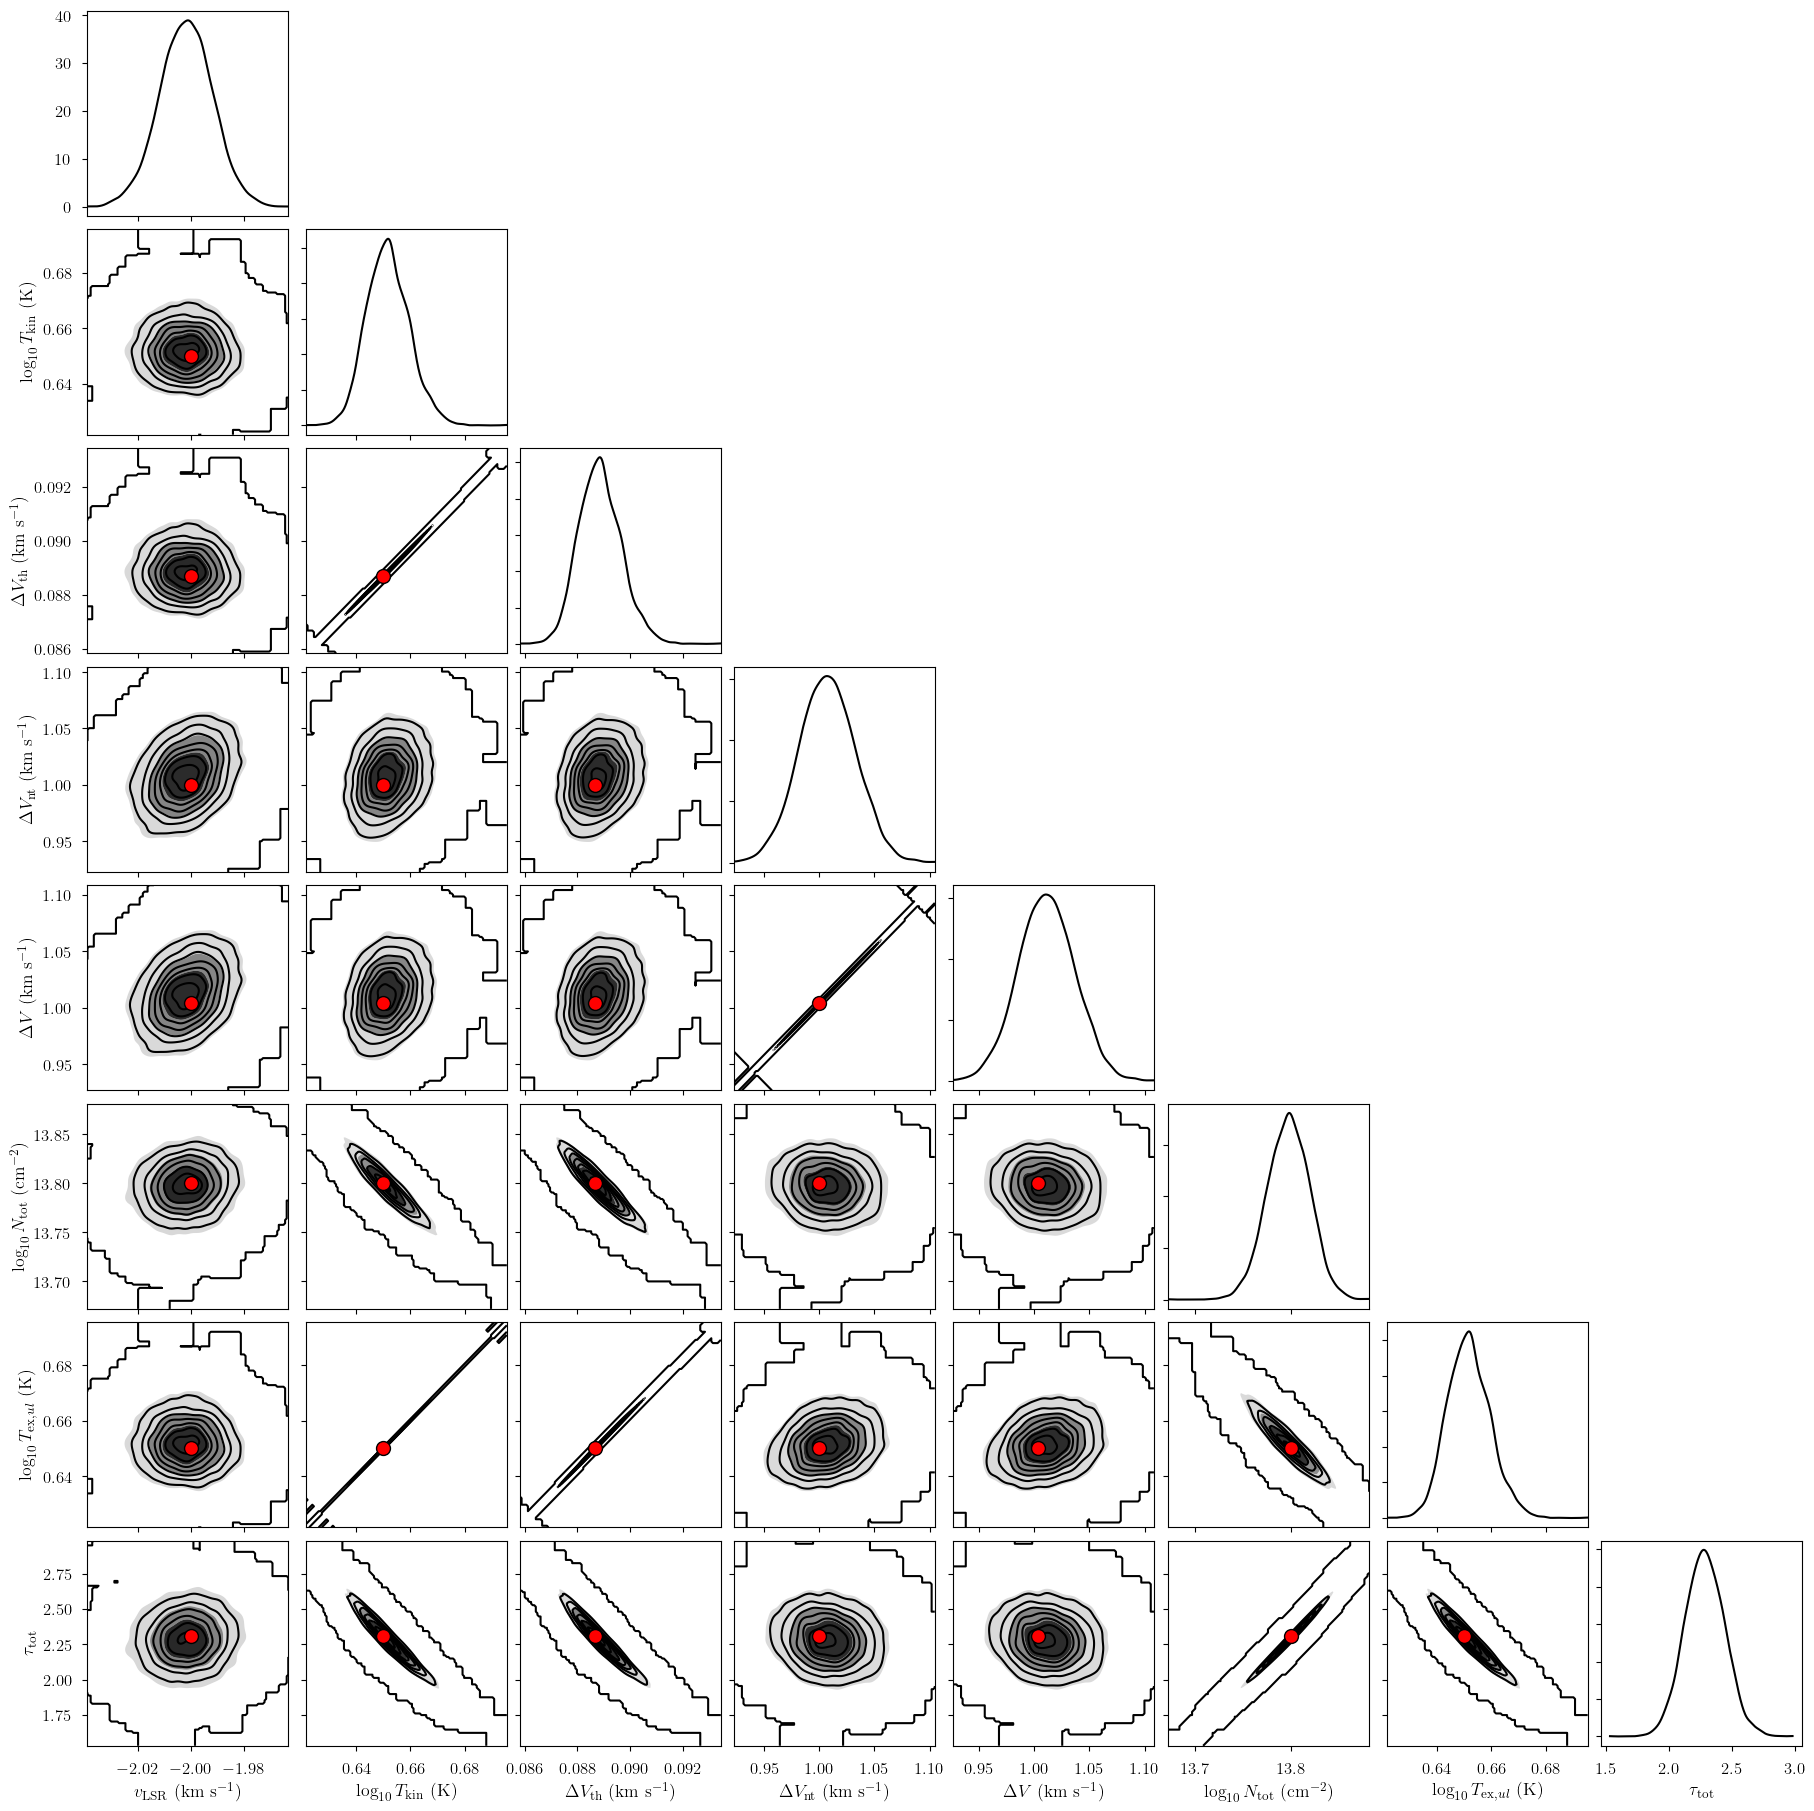

In [22]:
cloud = 1

# subset of sim_params
my_sim_params = {}
for var_name in model.cloud_deterministics:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=my_sim_params, # truths
)

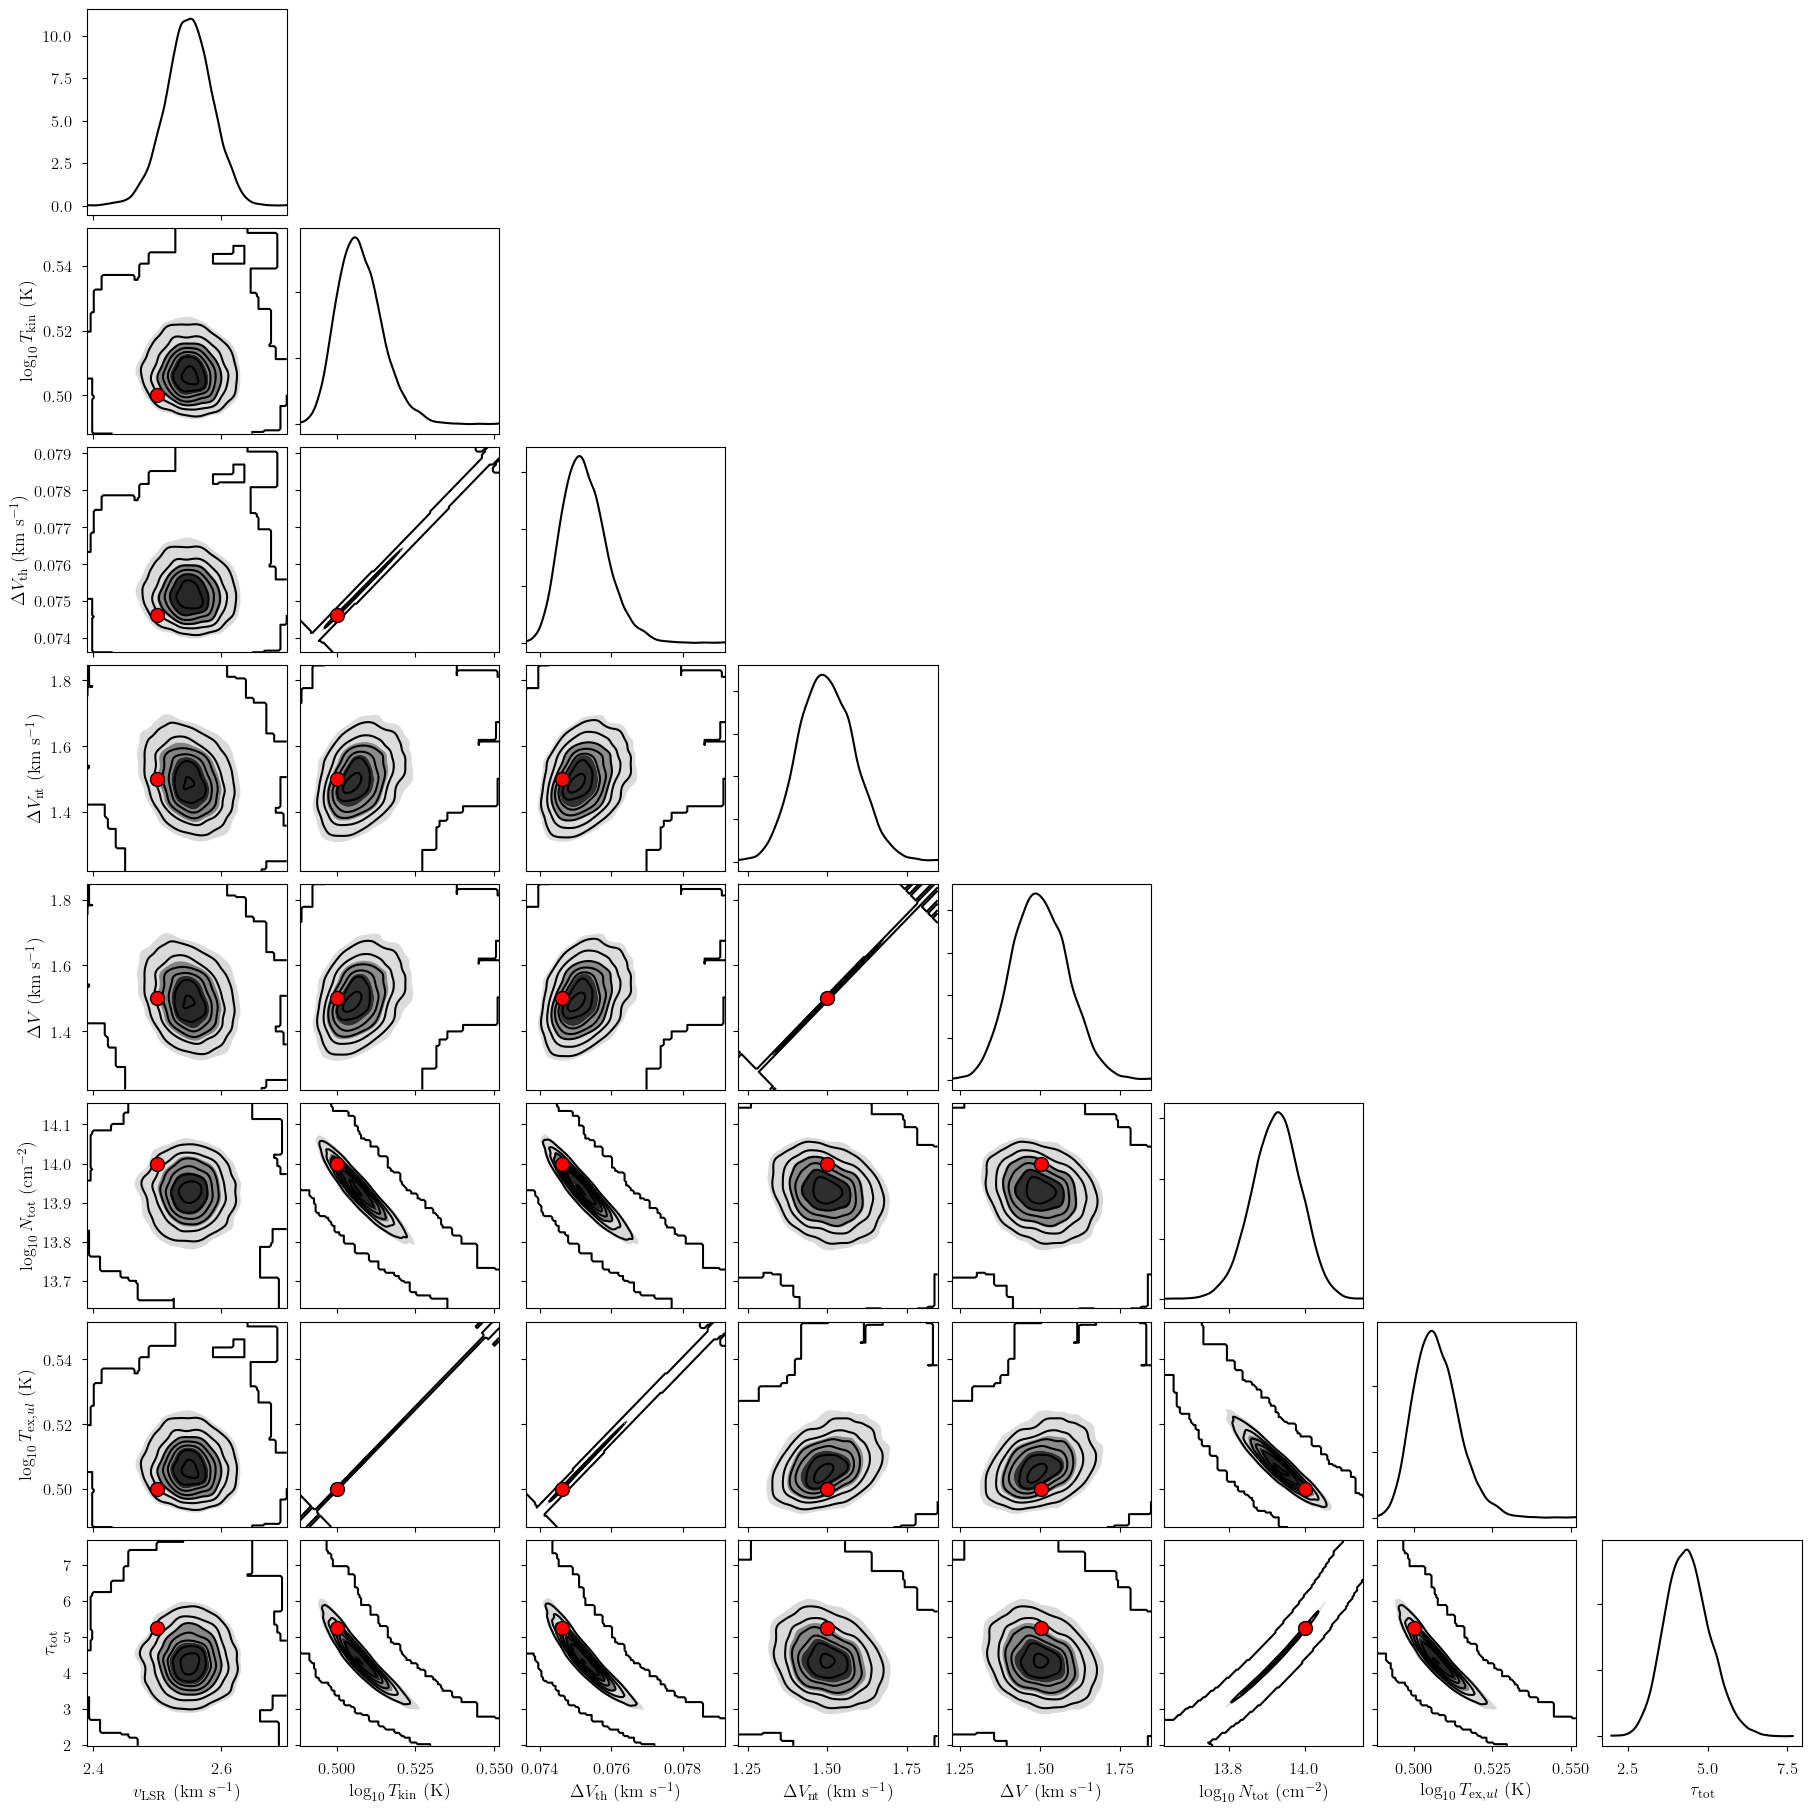

In [23]:
cloud = 2

# subset of sim_params
my_sim_params = {}
for var_name in model.cloud_deterministics:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=my_sim_params, # truths
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [24]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_deterministics
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -3441.9452824798577


mean     sd  hdi_16%  hdi_84%
velocity[0]               0.019  0.015    0.005    0.035
velocity[1]              -2.002  0.010   -2.013   -1.993
velocity[2]               2.549  0.036    2.513    2.584
log10_Tkin[0]             0.601  0.006    0.594    0.606
log10_Tkin[1]             0.652  0.008    0.644    0.659
log10_Tkin[2]             0.507  0.007    0.500    0.513
fwhm_thermal[0]           0.084  0.001    0.083    0.084
fwhm_thermal[1]           0.089  0.001    0.088    0.090
fwhm_thermal[2]           0.075  0.001    0.075    0.076
fwhm_nonthermal[0]        1.291  0.040    1.252    1.330
fwhm_nonthermal[1]        1.007  0.026    0.981    1.032
fwhm_nonthermal[2]        1.499  0.089    1.406    1.579
fwhm[0]                   1.294  0.040    1.254    1.332
fwhm[1]                   1.011  0.026    0.986    1.037
fwhm[2]                   1.501  0.089    1.408    1.580
log10_N[0]               13.909  0.026   13.881   13.933
log10_N[1]               13.797  0.022   13.774   13.818
log10_N[2]               13.925  0.064   13.868   13.995
log10_Tex_ul[0]           0.601  0.006    0.594    0.606
log10_Tex_ul[1]           0.652  0.008    0.644    0.659
log10_Tex_ul[2]           0.507  0.007    0.500    0.513
LTE_weights[0, 0 0 1 1]   0.189  0.002    0.187    0.191
LTE_weights[0, 0 0 1 2]   0.377  0.003    0.375    0.381
LTE_weights[0, 1 0 1 1]   0.048  0.001    0.048    0.049
LTE_weights[0, 1 0 1 2]   0.097  0.001    0.095    0.098
LTE_weights[0, 1 0 2 1]   0.048  0.001    0.048    0.049
LTE_weights[0, 1 0 2 2]   0.096  0.001    0.095    0.097
LTE_weights[0, 1 0 2 3]   0.144  0.002    0.143    0.146
LTE_weights[1, 0 0 1 1]   0.176  0.002    0.175    0.178
LTE_weights[1, 0 0 1 2]   0.353  0.004    0.349    0.356
LTE_weights[1, 1 0 1 1]   0.053  0.001    0.052    0.053
LTE_weights[1, 1 0 1 2]   0.105  0.001    0.104    0.106
LTE_weights[1, 1 0 2 1]   0.052  0.001    0.052    0.053
LTE_weights[1, 1 0 2 2]   0.105  0.001    0.103    0.106
LTE_weights[1, 1 0 2 3]   0.157  0.002    0.155    0.159
LTE_weights[2, 0 0 1 1]   0.215  0.002    0.213    0.217
LTE_weights[2, 0 0 1 2]   0.429  0.004    0.426    0.434
LTE_weights[2, 1 0 1 1]   0.040  0.001    0.039    0.040
LTE_weights[2, 1 0 1 2]   0.079  0.001    0.078    0.081
LTE_weights[2, 1 0 2 1]   0.039  0.001    0.039    0.040
LTE_weights[2, 1 0 2 2]   0.079  0.001    0.077    0.080
LTE_weights[2, 1 0 2 3]   0.118  0.002    0.116    0.120
Tex[113123.3687, 0]       3.988  0.059    3.921    4.038
Tex[113123.3687, 1]       4.485  0.081    4.401    4.561
Tex[113123.3687, 2]       3.217  0.054    3.159    3.261
Tex[113144.19, 0]         3.988  0.059    3.921    4.038
Tex[113144.19, 1]         4.485  0.081    4.401    4.561
Tex[113144.19, 2]         3.217  0.054    3.159    3.261
Tex[113170.535, 0]        3.988  0.059    3.921    4.038
Tex[113170.535, 1]        4.485  0.081    4.401    4.561
Tex[113170.535, 2]        3.217  0.054    3.159    3.261
Tex[113191.325, 0]        3.988  0.059    3.921    4.038
Tex[113191.325, 1]        4.485  0.081    4.401    4.561
Tex[113191.325, 2]        3.217  0.054    3.159    3.261
Tex[113488.142, 0]        3.988  0.059    3.921    4.038
Tex[113488.142, 1]        4.485  0.081    4.401    4.561
Tex[113488.142, 2]        3.217  0.054    3.159    3.261
Tex[113490.985, 0]        3.988  0.059    3.921    4.038
Tex[113490.985, 1]        4.485  0.081    4.401    4.561
Tex[113490.985, 2]        3.217  0.054    3.159    3.261
Tex[113499.643, 0]        3.988  0.059    3.921    4.038
Tex[113499.643, 1]        4.485  0.081    4.401    4.561
Tex[113499.643, 2]        3.217  0.054    3.159    3.261
Tex[113508.934, 0]        3.988  0.059    3.921    4.038
Tex[113508.934, 1]        4.485  0.081    4.401    4.561
Tex[113508.934, 2]        3.217  0.054    3.159    3.261
Tex[113520.4215, 0]       3.988  0.059    3.921    4.038
Tex[113520.4215, 1]       4.485  0.081    4.401    4.561
Tex[113520.4215, 2]       3.217  0.054    3.159    3.261
tau[113123.3687, 0]       0.040  0.00